### <span style="color:rgb(237,127,16)">Optimization for Machine Learning - Advanced gradient descent lectures</span>

### <span style="color:rgb(237,127,16)">Master 2 IASD & Master 2 MASH, 2021-2022</span>


# <span style="color:rgb(237,127,16)">Lab 02 - Nonconvex optimization and gradient descent</span>


Lecture notes for this course are available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/GD/LectureNotesOML-GD.pdf).

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/GD/SourcesLabGD02.zip).

For any comment regarding this notebook (including typos), please send an email to: **clement.royer@dauphine.psl.eu**.

# <span style="color:rgb(237,127,16)">Introduction</span>

In this lab session, we continue our study of gradient descent by looking at nonconvex optimization problems. In particular, we will empirically verify that gradient descent almost surely avoids saddle points, and that adding noise is beneficial to rapidly move away from these saddle points.


*Note: All blocks of this notebook are built to be run sequentially. In particular, the next block should be executed before going any further.*

In [1]:
# Preamble: useful toolboxes, librairies, functions, etc.

# Display
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn, uniform, choice # Probability distributions

# SciPy - Efficient mathematical calculation
from scipy.linalg import norm # Euclidean norm
from scipy.linalg import svdvals # Singular value decomposition

# <span style="color:rgb(237,127,16)">Part 1 - A nonconvex optimization problem</span>

In this section, we apply gradient descent to a nonconvex optimization formulation derived from the low-rank matrix completion setting.

## 1.1 Problem data

We consider a data matrix $\mathbf{M} \in \mathbb{R}^{d \times d}$ assumed to be symmetric positive semidefinite and low rank, which means that the number of positive eigenvalues of $\mathbf{M}$ is $r \ll d$, all the other eigenvalues being $0$. Given a limited number of observations $s$ of $\mathbf{M}$, our goal is to find an approximation of this matrix.

**Question.** ***Show that a matrix $\mathbf{M}$ satisfying these assumptions can always be written as $\mathbf{M}=\mathbf{U}\mathbf{U}^T$ with $\mathbf{U} \in \mathbb{R}^{d \times r}$.***

***Hint: Use the eigenvalue decomposition of $\mathbf{M}$ and modify it to obtain the desired form for $\mathbf{U}$.***

**Answer**

Since $\mathbf{M}$ is a symmetric matrix, there exists an orthogonal matrix $\mathbf{P} \in \mathbb{R}^{d \times d}$ 
(such that $\mathbf{P}\mathbf{P}^T = \mathbf{P}^T \mathbf{P} = \mathbf{I}_d$) and a diagonal matrix $\mathbf{\Lambda} \in \mathbb{R}^{d \times d}$ containing the eigenvalues of $\mathbf{M}$ such that 
$$
    \mathbf{M} = \mathbf{P} \mathbf{\Lambda} \mathbf{P}^T.
$$
Since $\mathbf{M}$ is positive semidefinite and of (low) rank $r$, we know that the eigenvalues of $\mathbf{M}$ (i.e. the diagonal coefficients of $\mathbf{\Lambda}$) satisfy
$$
    \Lambda_{11} \ge \Lambda_{22} \ge \dots \ge \Lambda_{rr} > \Lambda_{(r+1)(r+1)} = \dots = \Lambda_{dd} = 0.
$$

Consider now the matrix
$$
    \Gamma = \left(
            \begin{array}{cccc}
                \sqrt{\Lambda_{11}} &0 &\cdots &0 \\
                0 &\sqrt{\Lambda_{22}} &\cdots &0 \\
                \vdots & \cdots &\ddots &0 \\
                0 &\cdots &0 &\sqrt{\Lambda_{rr}}
            \end{array}
            \right)
    \in \mathbb{R}^{d \times r}.
$$

*Implementation: Implement a routine that takes as inputs three values $d$, $r \le d$, $s \le d^2$ and outputs a random matrix in $\mathbb{R}^{d \times d}$ of rank $r$, as well as a matrix obtained by sampling $s$ entries of this matrix.*

In [2]:
# Generate a random, low-rank matrix and get a sampled version
# This code is adapted from the lab session of Irène Waldspurger, M2 IASD 2020-2021.

def datamatrix(d,r,nb_s):
    '''
        Generation of a random, low-rank matrix as well as a subsampled matrix approximation.
        This code is adapted from the lab session of Irène Waldspurger at M2 IASD 2020-2021.
        
        Inputs:
            d: Matrix dimension (the output matrices will be d-by-d)
            r: Rank of the matrix
            nb_s: Number of subsampled entries
        
        Outputs:
            M: Data matrix, of size d x d and of rank r
            S: Mask defining the sampling pattern: size d x d, formed by zeroes and ones
            M_sampled: Subsampled matrix
            U: Factor data matrix
    '''

    # True low-rank factor and matrix
    U = randn(d,r)
    M = np.dot(U,np.transpose(U))

    # Consider a matrix partially filled out with s entries of M
    subset = choice(d*d,nb_s,replace=False)
    S = np.zeros(d*d)
    S[subset] = 1
    S = S.reshape((d,d))
    M_sampled = M*S # Entrywise product

    return M,S,M_sampled,U


*Implementation: Plot the result of the function for specific values of $d$,$r$ and $nb\_s$.*

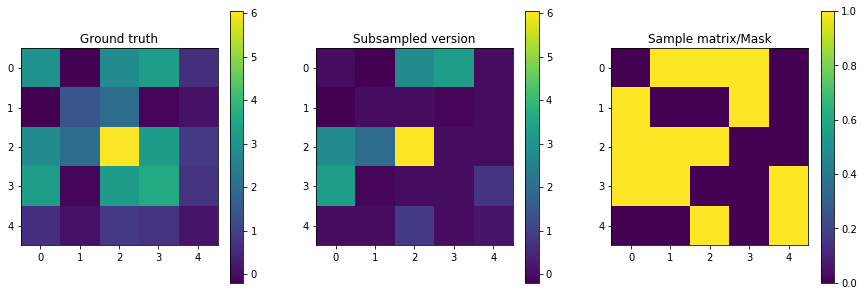

In [3]:
d = 5 # Matrix size is d*d
r = 2 # Intrisic rank
nb_s = 13 # Number of observed entries

# Fix random seed for reproducibility
np.random.seed(1)

M,S,M_sampled,U = datamatrix(d,r,nb_s)


# Plot the results
plt.figure(figsize=(15,5))
plt.get_cmap('twilight')
plt.subplot(131)
plt.title('Ground truth')
plt.imshow(M)
plt.colorbar()
plt.subplot(132)
plt.title('Subsampled version')
plt.imshow(M_sampled)
plt.colorbar()
plt.subplot(133)
plt.title('Sample matrix/Mask')
plt.imshow(S)
plt.colorbar()

## 1.2 Nonconvex formulation and derivatives

We now focus on a nonconvex formulation of this problem. The classical, convex optimization approach consists in solving
$$
    \mathrm{minimize}_{\mathbf{W} \in \mathbb{R}^{d \times d}} \frac{1}{2} \sum_{(i,j) \in \mathcal{S}} \left( \mathbf{W}_{ij}-\mathbf{M}_ij\right)^2
$$
where $\mathcal{S} \subset \{1,\dots,d\}^2$ represents the set of entries of the data matrix $\mathbf{M}$ that are observed. This problem is convex, but requires the manipulation of a $d \times d$ matrix. In addition, the solution need not be low rank: in fact, to guarantee that the solution will possess the same properties add the constraint $\mathrm{rank}(\mathbf{W})=r$ in order for the problem to guarantee a low-rank approximation, plus a constraint of the form $\mathbf{W} \succeq \mathbf{0}$ to guarantee that $\mathbf{W}$ has (like $\mathbf{M}$) only nonnegative eigenvalues.

Overall, the problem we should look at is
$$
   \mathrm{minimize}_{\mathbf{W} \in \mathbb{R}^{d \times d}} \frac{1}{2} \sum_{(i,j) \in \mathcal{S}} \left( \mathbf{W}_{ij}-\mathbf{M}_ij\right)^2 \quad \mathrm{subject\ to} \quad 
   \mathbf{W}=\mathbf{W}^T \succeq \mathbf{0},\ \mathrm{rank}(\mathbf{W}) \le r.
$$

Instead of this formulation, we adopt the Burer-Monteiro approach and reformulate the problem using a factored representation of the problem variable $\mathbf{W}$ that highlights its low-rank structure. This leads to the following formulation:
$$
    \mathrm{minimize}_{\mathbf{U} \in \mathbb{R}^{d \times r}} \frac{1}{2}\sum_{(i,j) \in \mathcal{S}} \left( [\mathbf{U}\mathbf{U}^T]_{ij}-\mathbf{M}_{ij}\right)^2.
$$
Compared to the original formulation, our approximation of $\mathbf{M}$ is given by $\mathbf{U}\mathbf{U}^T$, which is by construction a rank-$r$ matrix, *but we only solve the problem in $\mathbf{U} \in \mathbb{R}^{d \times r}$*. This problem is unconstrained in $\mathbf{U}$ and involves only $dr$ variables by explicitly enforcing the low-rank 
property.

We would like to apply gradient descent to the following problem
$$
    \mathrm{minimize}_{\mathbf{U} \in \mathbb{R}^{d \times r}}\ f(\mathbf{U}):=
    \frac{1}{2}\sum_{(i,j) \in \mathcal{S}} \left([\mathbf{U}\mathbf{U}^T]_{ij}-\mathbf{M}_{ij}\right)^2
$$
There are two ways to approach this problem: the first one consists in viewing this problem as one on $\mathbb{R}^{d \times r}$, and do a standard gradient descent procedure. 

The second approach preserves the matrix structure of the variables, and defines the gradient of $f$ as a matrix in $\mathbb{R}^{d \times r}$ (similarly to the vector case, in which $\nabla \phi(\mathbf{x}) \in \mathbb{R}^d$ for any function $\phi: \mathbb{R}^d \rightarrow \mathbb{R}$ and $\mathbf{x} \in \mathbb{R}^d$). In our case, we define the gradient of $f$ with respect to any $\mathbf{U} \in \mathbb{R}^{d \times r}$ as:
$$
    \nabla f(\mathbf{U}) := (\mathbf{E}+\mathbf{E}^T)\mathbf{U} \quad \mbox{where} \quad 
    \mathbf{E}:= (\mathbf{U}\mathbf{U}^T-\mathbf{M}) \otimes \mathbf{S},
$$
with $\otimes$ denoting the Hadamard/entrywise matrix product, and $\mathbf{S} \in \mathbb{R}^{d \times d}$ is 
defined by 

$$
    \mathbf{S}_{ij} = 
    \left\{
        \begin{array}{ll}
            1 &\mbox{if $(i,j) \in \mathcal{S}$} \\
            0 &\mbox{otherwise.}
        \end{array}
    \right.
$$

*Implementation: Write the following two functions:*
- *A function* f_mat *that computes the function value;*
- *A function* fg_mat *that outputs both the function and its gradient (defined according to the formula above).*

In [4]:
# Objective function for the nonconvex matrix factorization problem
def f_mat(U,M_S,S):
    '''
        Function value for the low-rank matrix factorization problem.
        The solution of this problem is a matrix U such that U*U^T agrees as best as possible with M_S on its 
        non-zero entries.
        
        Inputs:
            U: d-by-r matrix (decision variables)
            M_S: Samples from the data matrix
            S: Sampling pattern
            
        Output:
            f: Value of the low-rank matrix functional at U
    '''
    E = np.dot(U,np.transpose(U))-M_S
    E = E * S
    return 0.5*np.sum(E**2)

# Objective and gradient vector for the nonconvex matrix factorization problem
def fg_mat(U,M_S,S):
    '''
        Objective and gradient vector for the low-rank matrix factorization problem.
        The solution of this problem is a matrix U such that U*U^T agrees as best as possible with M_S on its 
        non-zero entries.   
        
        Inputs:
            U: d-by-r matrix (decision variables)
            M_S: Samples from the data matrix
            S: Sampling pattern
            
        Output:
            f: Value of the low-rank matrix functional at U
            G: Value of the gradient of this functional (defined in a matrix sense) at U
    '''
    E = np.dot(U,np.transpose(U))-M_S
    E = E * S
    f = 0.5*np.sum(E**2)
    G = np.dot(E+np.transpose(E),U)
    return f,G

**Question.** ***Show that the zero matrix in $\mathbb{R}^{d \times r}$ satisfies the first-order optimality condition. Is it a local minimum?***

**Answer**

The formula for $\nabla f$ readily gives $\nabla f(\mathbf{zero})=\mathbf{zero}$, thus the zero matrix satisfies the first-order optimality condition.

We can now implement a gradient descent

In [5]:
def gd_matrix(U0,fun,fungrad,f_base,step,linesearch=False,n_iter=10000, verbose=False): 
    """
        A code for gradient descent on low-rank matrix-type problems.
        
        Inputs:
            U0: Initial (rectangular) matrix
            fun: Objective function, returns f(U) for every U
            fungrad: Returns both the objective function and its gradient
            f_base: A base value to assess convergence
            step: Initial value of the stepsize
            linesearch: Boolean indicating whether or not a line search should be performed
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
      
        Outputs:
            U_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length at most n_iter+1)
            ngvals: History of gradient norms (output as a Numpy array of length at most n_iter+1)
            nits: Number of iterations actually performed
            flag: Termination flag
                0: Convergence in terms of function value (decrease of f_base by 1e-4)
                1: Convergence in terms of gradient norm (below 1e-3, normalized by norm(U_output))
                2: Maximum number of iterations reached
            
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # gradient norm history
    ngvals = []
    
    # Initial value of current iterate   
    U = U0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective and gradient value
    obj,G = fungrad(U)
    objvals.append(obj)
    ngrad = norm(G)
    ngvals.append(ngrad)

    # Plot the initial values if asked to
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "ngrad"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))
    
    # Stopping boolean
    if (obj<=1e-4*f_base):
        flag=0
    elif (ngrad<=1e-3*norm(U)):
        flag=1
    else:
        flag=2
        
    stopping=(flag==2)
    
    ####################
    # Main loop
    while stopping:
        
        # Select the stepsize and perform the update
        if linesearch:
            if k>0:
                step = 1.1*step
            fval = fun(U-step*G)
            ngrad2 = ngrad**2
            # Loop to increase the value of L if necessary
            while (fval-obj>-0.5*step*ngrad2):
                step = step/2
                fval = fun(U-step*G)
        
        U = U - step * G
        
        # Compute the new objective and gradient
        obj,G = fungrad(U)
        objvals.append(obj)
        ngrad = norm(G)
        ngvals.append(ngrad)
        
        # Plot relevant information if asked to
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
        
        # Stopping boolean
        if (obj<=1e-4*f_base):
            flag=0
        elif (ngrad<=1e-3*norm(U)):
            flag=1
        else:
            flag=2
        stopping = (flag==2)
    
    # End main loop
    ######################
    
    # Output
    U_output = U.copy()
    nits = k
        
    return U_output, np.array(objvals), np.array(ngvals),nits,flag

0
Objective function: 3.294970662944837e-05
Normalized gradient norm: 0.016902753742291565


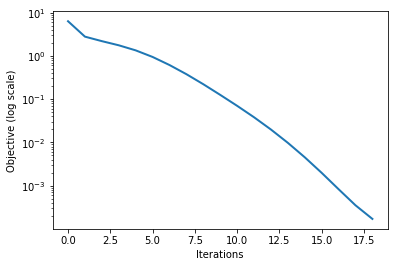

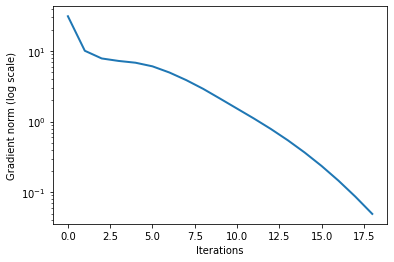

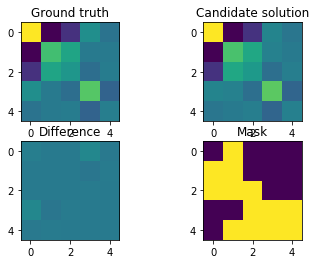

In [6]:
# Validation on a small-dimensional example

d=5
r=2
nb_s=13

M,S,M_s,U_star = datamatrix(d,r,nb_s)

fbase = 0.5*(np.sum(M_s**2))

# Run gradient descent
U0 = randn(d,r)
#U0 = U_star
U_out,obj_out,ng_out,nits,flag = gd_matrix(U0,lambda U: f_mat(U,M_s,S),lambda U: fg_mat(U,M_s,S),fbase,1.,True,10000,False)

#print(nits)
print(flag)
# Plot the results
print("Objective function:",obj_out[-1]/(norm(M_s)**2))
print("Normalized gradient norm:",ng_out[-1]/norm(U_out))
M_out = np.dot(U_out,np.transpose(U_out))

plt.figure(1)
plt.semilogy(obj_out/norm(M_s), lw=2)
plt.xlabel('Iterations')
plt.ylabel('Objective (log scale)')
plt.figure(2)
plt.semilogy(ng_out, lw=2)
plt.xlabel('Iterations')
plt.ylabel('Gradient norm (log scale)')
plt.figure(3)
plt.subplot(221)
plt.title('Ground truth')
plt.imshow(M)
plt.subplot(222)
plt.title('Candidate solution')
plt.imshow(M_out,vmin=np.amin(M_out),vmax=np.amax(M_out))
plt.subplot(223)
plt.title('Difference')
plt.imshow(M-M_out,vmin=np.amin(M_out),vmax=np.amax(M_out))
plt.subplot(224)
plt.title('Mask')
plt.imshow(S)

*Implementation: Run multiple instances of this problem. For any instance, consider it*
-  An instance converging to a global solution if the final function value is below $10^{-4}\|\mathbf{M}_S\|^2$;
- An instance converging to a critical point if the previous test fails but 
the final gradient norm is below $10^{-3}\|\mathbf{U}_K\|$, where $\mathbf{U}_K$ is the last iterate;
- A failure otherwise.

*Compare the ratio of such instances for small values of $nb_s$ and large 
values.*

10 - 
12 - 
14 - 
16 - 
18 - 
20 - 
22 - 
24 - 
26 - 
28 - 
30 - 
32 - 
34 - 
36 - 
38 - 


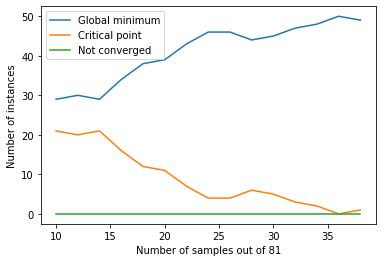

In [7]:
# Implementation - Running multiple instances

d=9
r=1
vals_s = range(10,40,2)
len_s = len(vals_s)
counter = np.zeros((len_s,3))
#
for n_it in range(0,len_s):
    nb_s = vals_s[n_it]
    print(str(nb_s) + ' - '),
    for i in range(0,50):
        M,S,M_s,U_star = datamatrix(d,r,nb_s)
        nMs2 = 0.5*norm(M_s)**2
        U0 = randn(d,r)
        U_out,obj_out,ng_out,_,flag = gd_matrix(U0,lambda U: f_mat(U,M_s,S),lambda U: fg_mat(U,M_s,S),nMs2,1.,True,20000,False)
        counter[n_it,flag]+=1
#
plt.xlabel('Number of samples out of '+str(d**2))
plt.ylabel('Number of instances')
plt.plot(vals_s,counter[:,0],label='Global minimum')
plt.plot(vals_s,counter[:,1],label='Critical point')
plt.plot(vals_s,counter[:,2],label='Not converged')
plt.legend()

**Question.** ***In the above method, we have selected a stepsize $\alpha_k$ through a 
backtracking line-search procedure. More precisely, the method chooses $\alpha_k$ as $\tfrac{1}{2^{j_k}}$, where $j_k$ is the smallest nonnegative integer such that the condition
$$
f\left(\mathbf{w}_k-\frac{1}{2^{j_k}}\nabla f(\mathbf{w}_k)\right) < f(w_k) - 0.5 \frac{1}{2^{j_k}}\|\nabla f(\mathbf{w}_k)\|^2.
$$
is satisfied. This so-called Armijo-Wolfe condition is very classical in nonlinear optimization, as it removes the need for knowing the Lipschitz constant. It is also used in several ML implementations. It can be shown that if $w_k$ is not a local minimum, the condition is satisfied for $\alpha_k < \frac{1}{2 L}$.***

***Discuss the advantages and drawbacks of such an approach.***

**Answers** 

The line-search approach allows to compute a step that is tailored to the current landscape of the function; this stepsize can potentially be much larger than $1/L$ (that we use for $\mathcal{C}^{1,1}_L$ functions. It also leads to guaranteed progress at every iteration, in a way that resembles the descent property used in convergence rate analyses.

On the other hand, performing a line search requires evaluations of the function value, while the gradient descent iteration does not *(NB: In the algorithm, we did compute the function values, but only for plotting them afterwards - they are not needed for the optimization, and in practice would not be computed.)*. Another common issue with backtracking line search is that it can produce very small stepsizes (other, more sophisticated line-search conditions can be used to mitigate this issue).

# <span style="color:rgb(237,127,16)"> Part 2 - Gradient descent and local minima</span>

In this section, our goal is to observe the following phenomenon: ***gradient descent escapes saddle points of nonconvex functions almost surely***.

*Implementation: Implement a code for gradient descent that outputs all function values and gradient norms computed throughout the algorithmic run.*

In [8]:
def gd(w0,fun,gfun,step,n_iter=100, verbose=False): 
    """
        A code for gradient descent on quadratic functions.
        
        Inputs:
            w0: Initial vector
            fun: Objective function, returns f(w) for every w
            gfun: Gradient of the objective function, gfun(w) returns the gradient vector at w
            step: Value of the stepsize
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
      
        Outputs:
            w_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length n_iter+1)
            ngvals: History of gradient norms (output as a Numpy array of length n_iter+1)
            
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # gradient norm history
    ngvals = []
    
    # Initial value of current iterate   
    w = w0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective
    obj = fun(w)
    objvals.append(obj)
    
    # Current gradient value
    g = gfun(w)
    ngrad = norm(g)
    ngvals.append(ngrad)

    # Plot the initial values if asked to
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "ngrad"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))
    
    ####################
    # Main loop
    while (k < n_iter):
        
        # Compute the gradient
        g = gfun(w)
        
        # Select the stepsize and perform the update
        w[:] = w - step * g
        
        # Compute the new objective value 
        obj = fun(w)
        objvals.append(obj)
        
        # Compute the new gradient value
        g = gfun(w)
        ngrad = norm(g)
        ngvals.append(ngrad)
        
        # Plot relevant information if asked to
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
    
    # End main loop
    ######################
    
    # Output
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(ngvals)

## 2.1 A nonconvex quadratic toy problem

We consider the problem
$$
    \mbox{minimize}_{\mathbf{w} \in \mathbb{R}^d}\ q(\mathbf{w}):=\frac{1}{2} \mathbf{w}^T \mathbf{A} \mathbf{w}
$$
where $\mathbf{A}$ is a diagonal matrix with entries $(1,\dots,1,-\lambda)$ on the diagonal and $\lambda \in (0,1]$. 
Note that $\|\mathbf{A}\|=1$ by definition of the operator norm.



**Question.** ***What is the minimum value of this problem?***

**Answer** This problem is unbounded below. Taking $\mathbf{w}=t\mathbf{e}_d$ (last vector of the canonical basis in \mathbb{R}^d) for some $t \in \mathbb{R}$ gives 
$$
    q(\mathbf{w}) = -\frac{t^2}{2}\lambda \rightarrow -\infty \quad \mbox{as} \quad t \rightarrow \pm \infty.
$$
Therefore, the function does not have a minimum.

**Question.** ***Compute $\nabla q(\mathbf{w})$ for all $\mathbf{w} \in \mathbb{R}^d$, and show that the gradient mapping is $1$-Lipschitz continuous.***

**Answer** Re-using our argument from Question 3, we obtain for all $\mathbf{w} \in \mathbb{R}^d$ that
$$
    \nabla q(\mathbf{w}) = \mathbf{A} \mathbf{w}.
$$
Thus, for any $\mathbf{v},\mathbf{w} \in \mathbb{R}^d$, we have
$$
    \|\nabla q(\mathbf{w})-\nabla q(\mathbf{v})\| 
    = \|\mathbf{A}(\mathbf{w}-\mathbf{v})\| 
    \le \|\mathbf{A}\| \|\mathbf{w}-\mathbf{v}\|.
$$
As a result, the gradient mapping $\nabla q$ is $\|\mathbf{A}\|$-continuous, and using $\|\mathbf{A}\|=1$ concludes 
the argument.

**Question.** ***Justify that the objective function $q$ of this problem is nonconvex, and that $\mathbf{w}=\mathbf{0}$ is a saddle point for this problem.***

**Answer** We use the characterization of convexity through the Hessian. Here $\nabla^2 q(\mathbf{w})=\mathbf{A}$, 
and the eigenvalues of $\mathbf{A}$ are $1$ and $-\lambda<0$. As a result, $\mathbf{A}$ is not positive semidefinite, and the function cannot be convex: it is nonconvex.

Looking at $\mathbf{w}=\mathbf{0}$, we see that $\nabla q(\mathbf{0})= \mathbf{0}$, thus the origin is a critical point of the problem. But the origin cannot be a local minimum or a maximum, since the Hessian at this point (as at any other point) possesses both positive and negative eigenvalues. Therefore, the origin must be a saddle point.

## 3.2 Running gradient descent

We will now run multiple instances of gradient descent on this problem. To this end, we define a new Python class.

*Implementation: Define the nonconvex function described above and plot its level sets around the saddle point $\mathbf{0}$.*

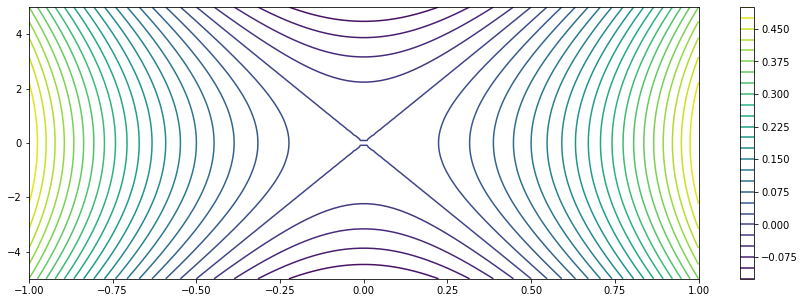

In [9]:
# Define relevant quantities
d = 2
lbda = 0.01
A = np.eye(d)
A[d-1,d-1] = -lbda

toy_f = lambda w : 0.5*w.dot(A.dot(w))
toy_g = lambda w : A.dot(w)


# Plot countours of the objective function if the dimension allows it
if d==2:
    delta = 5
    w1 = np.linspace(-1,1,100)
    w2 = np.linspace(-delta,delta,100)
    fw = [[toy_f(np.array([u1,u2])) for u1 in w1] for u2 in w2]
    plt.figure(figsize=(15,5))
    plt.contour(w1,w2,fw,levels=30)
    plt.colorbar()

**Question.** ***On this problem, how can you check that gradient descent has escaped the saddle point at the origin? Use the code template below to check that this happens almost surely.***

**Answer** 

At the origin, the function value is $0$. If the method reaches a point with negative function value, it 
will necessarily keep going downhill and reduce the function value further. We will thus use this criterion to 
certify whether or not the method has escaped the saddle point.

**Question.** ***Find a point (or a set of points) for which the method will necessarily converge towards the saddle 
point. Validate empirically that this is indeed the case.***

**Answer** 

It suffices to consider a point $\mathbf{w} \in \mbox{span}\{\mathbf{e}_1,\dots,\mathbf{e}_{d-1}\}$, i.e.
to ignore the last coordinate that corresponds to the negative eigenvalue.

GD escaped the saddle point  10  times out of  11  trials


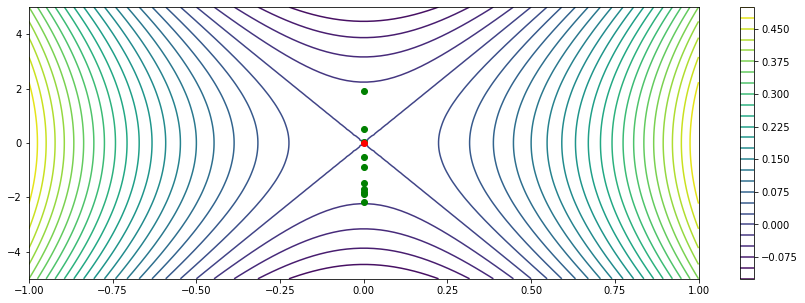

In [10]:
# Draw a bunch of random points and plot the result

ntrials = 10

step = 1

# Boolean to introduce the point of Question 12-b)
failpt = True

# Define initial points and final values according to the boolean
if failpt:
    Wf = np.zeros((ntrials+1,d))
    vf = np.zeros(ntrials+1)
else:
    Wf = np.zeros((ntrials,d))
    vf = np.zeros(ntrials)

# Counting the number of "good trials" (those for which GD escaped the saddle point)
goodtrials = 0

# Run multiple instances of GD
for i in range(ntrials):
    w0 = uniform([-1,-1],[1,1],size=d)
    Wf[i,:], obj_q, ngrad_q = gd(w0,toy_f,toy_g,step,100)
    vf[i] = obj_q[-1]
    if vf[i]<0:
        goodtrials += 1
        
# Add a point of failure for GD
if failpt:
    w0 = np.ones(d)
    w0[-1] = 0 # Remove the component in the negative eigenspace
    Wf[ntrials,:], obj_q, ngrad_q = gd(w0,toy_f,toy_g,step,100)
    vf[ntrials] = obj_q[-1]
    if vf[ntrials]<0:
        goodtrials +=1
        
print('GD escaped the saddle point ',goodtrials,' times out of ', ntrials+1,' trials')
    
# Plot the results if dimension allows it
if d==2:
    npts = vf.size
    plt.figure(figsize=(15,5))
    plt.contour(w1,w2,fw,levels=30)
    plt.colorbar()
    for i in range(npts):
        if vf[i]<0:
            plt.plot(Wf[i,0],Wf[i,1],'o',color='green')
        else:
            plt.plot(Wf[i,0],Wf[i,1],'o',color='red')

*Extra: Try injecting noise in gradient descent every k iterations to see whether it helps escaping the vicinity of a saddle point.*

In [11]:
# The last part of this notebook is adapted from Irène Waldspurger lab session in IASD, 2019-2021.
# Version 1.2 - C. W. Royer, October 2021.